# Projections GLOB vs HMA of Near-Surface Air Temperature
conda env: `phd_v3` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period_future = slice('2015','2100')
period_past = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()
seasons = ['Annual', 'DJFMA', 'JJAS']
# seasons = ['Annual']

# HMA for full domain and the following for the above zones
zones = ['GLOB', 'GLOB-land', 'NH-land', 'NH-land-60', 'HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [
        [slice(None), slice(None)], 
        [slice(None), slice(None)], 
        [slice(None), slice(0,90)], 
        [slice(None), slice(0,60)], 
        [lonlim, latlim],
        [lonlim_HK, latlim_HK],
        [lonlim_HM, latlim_HM],
        [lonlim_TP, latlim_TP]
    ], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

var = 'tas'
table = u.get_table(var)
label, units, levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
label

'Near-Surface Air Temperature'

## Load topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'})
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load land/sea mask
https://ldas.gsfc.nasa.gov/gldas/vegetation-class-mask

In [4]:
mask = xr.open_dataset('/data/mlalande/GLDASp5_landmask_10d.nc4').GLDAS_mask[0]

## Load models

In [5]:
list_models = u.get_model_names_projections()
# list_models = list_models[:1]
# list_models = ['EC-Earth3']

resolution = [None]*len(list_models)

da_past_ym_list = [[None] * (len(list_models)) for i in range(len(seasons))]

scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
da_ssp126_ym_list = [[None] * (len(list_models)) for i in range(len(seasons))]
da_ssp245_ym_list = [[None] * (len(list_models)) for i in range(len(seasons))]
da_ssp370_ym_list = [[None] * (len(list_models)) for i in range(len(seasons))]
da_ssp585_ym_list = [[None] * (len(list_models)) for i in range(len(seasons))]

da_future_ym_list = [da_ssp126_ym_list, da_ssp245_ym_list, da_ssp370_ym_list, da_ssp585_ym_list]


for i, model in enumerate(list_models):
    print(model + ' ('+str(i+1)+'/'+str(len(list_models))+')')
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    
    #################
    ### Load past ###
    #################
    print('Load past')
    da_past = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
        combine='by_coords').sel(time=period_past)[var].load()
    
    np.testing.assert_equal((int(period_past.stop) - int(period_past.start) + 1)*12, da_past.time.size)
    
    # tas (K -> °C)
    #################################################################################

    da_past -= 273.15
        
    #################################################################################
    
    # Print resolution and save it
    lat = (da_past.lat[1] - da_past.lat[0]).values; lon = (da_past.lon[1] - da_past.lon[0]).values
    print(str(lon.round(3))+'°x'+str(lat.round(3))+'°')
    resolution[i] = str(lon.round(1))+'°x'+str(lat.round(1))+'°'
    
    for k, season in enumerate(seasons):
        print(season)
        # Make year_mean
        da_past_ym = u.year_mean(da_past, calendar=calendar, season=season)

        # Regrid
        regridder = xe.Regridder(da_past, elevation, 'bilinear', periodic=False, reuse_weights=True)
        da_past_ym_regrid = regridder(da_past_ym)

        # Remove last year for Annual and summer to fit to winter
        if season in ['Annual', 'JJAS']:
            da_past_ym_regrid = da_past_ym_regrid.isel(year=slice(0,-1))
        
        # Store result
        da_past_ym_list[k][i] = da_past_ym_regrid
    
    
    
    
    ###################
    ### Load future ###
    ###################
    print('Load future')
    for j, scenario in enumerate(scenarios):
        print(scenario)
        if model in ['IPSL-CM6A-LR', 'MRI-ESM2-0']:
            da_future = xr.open_mfdataset(
                '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*210012.nc', 
                combine='by_coords').sel(time=period_future)[var].load()
        else:
            da_future = xr.open_mfdataset(
                '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
                combine='by_coords').sel(time=period_future)[var].load()

        np.testing.assert_equal((int(period_future.stop) - int(period_future.start) + 1)*12, da_future.time.size)
        
        # tas (K -> °C)
        #################################################################################

        da_future -= 273.15

        #################################################################################
        
        for k, season in enumerate(seasons):
            print(season)
            # Make year_mean
            da_future_ym = u.year_mean(da_future, calendar=calendar, season=season)

            # Regrid
            da_future_ym_regrid = regridder(da_future_ym)
            
            # Remove last year for Annual and summer to fit to winter
            if season in ['Annual', 'JJAS']:
                da_future_ym_regrid = da_future_ym_regrid.isel(year=slice(0,-1))

            # Store result
            da_future_ym_list[j][k][i] = da_future_ym_regrid
        
    print('\n')

BCC-CSM2-MR (1/10)
Load past
1.125°x1.112°
Annual
Reuse existing file: bilinear_160x320_180x360.nc
DJFMA
Reuse existing file: bilinear_160x320_180x360.nc
JJAS
Reuse existing file: bilinear_160x320_180x360.nc
Load future
ssp126
Annual
DJFMA
JJAS
ssp245
Annual
DJFMA
JJAS
ssp370
Annual
DJFMA
JJAS
ssp585
Annual
DJFMA
JJAS


CNRM-CM6-1 (2/10)
Load past
1.406°x1.389°
Annual
Reuse existing file: bilinear_128x256_180x360.nc
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Reuse existing file: bilinear_128x256_180x360.nc
JJAS
Reuse existing file: bilinear_128x256_180x360.nc
Load future
ssp126
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp245
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp370
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp585
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS


CNRM-CM6-1-HR (3/10)
Load past
0.5°x0.495°
Annual
Reuse existing file: bilinear_360x720_180x360.nc
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Reuse existing file: bilinear_360x720_180x360.nc
JJAS
Reuse existing file: bilinear_360x720_180x360.nc
Load future
ssp126
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp245
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp370
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp585
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS


CNRM-ESM2-1 (4/10)
Load past
1.406°x1.389°
Annual
Reuse existing file: bilinear_128x256_180x360.nc
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Reuse existing file: bilinear_128x256_180x360.nc
JJAS
Reuse existing file: bilinear_128x256_180x360.nc
Load future
ssp126
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp245
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp370
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp585
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS


CanESM5 (5/10)
Load past
2.812°x2.767°
Annual
Reuse existing file: bilinear_64x128_180x360.nc
DJFMA
Reuse existing file: bilinear_64x128_180x360.nc
JJAS
Reuse existing file: bilinear_64x128_180x360.nc
Load future
ssp126
Annual
DJFMA
JJAS
ssp245
Annual
DJFMA
JJAS
ssp370
Annual
DJFMA
JJAS
ssp585
Annual
DJFMA
JJAS


IPSL-CM6A-LR (6/10)
Load past
2.5°x1.268°
Annual
Reuse existing file: bilinear_143x144_180x360.nc
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Reuse existing file: bilinear_143x144_180x360.nc
JJAS
Reuse existing file: bilinear_143x144_180x360.nc
Load future
ssp126
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp245
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp370
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp585
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS


MIROC-ES2L (7/10)
Load past
2.812°x2.767°
Annual
Reuse existing file: bilinear_64x128_180x360.nc
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Reuse existing file: bilinear_64x128_180x360.nc
JJAS
Reuse existing file: bilinear_64x128_180x360.nc
Load future
ssp126
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp245
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp370
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp585
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS


MIROC6 (8/10)
Load past
1.406°x1.389°
Annual
Reuse existing file: bilinear_128x256_180x360.nc
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Reuse existing file: bilinear_128x256_180x360.nc
JJAS
Reuse existing file: bilinear_128x256_180x360.nc
Load future
ssp126
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp245
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp370
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp585
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS


MRI-ESM2-0 (9/10)
Load past
1.125°x1.112°
Annual
Reuse existing file: bilinear_160x320_180x360.nc
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Reuse existing file: bilinear_160x320_180x360.nc
JJAS
Reuse existing file: bilinear_160x320_180x360.nc
Load future
ssp126
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp245
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp370
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
ssp585
Annual
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS


UKESM1-0-LL (10/10)
Load past
1.875°x1.25°
Annual
Reuse existing file: bilinear_144x192_180x360.nc
DJFMA
Reuse existing file: bilinear_144x192_180x360.nc
JJAS
Reuse existing file: bilinear_144x192_180x360.nc
Load future
ssp126
Annual
DJFMA
JJAS
ssp245
Annual
DJFMA
JJAS
ssp370
Annual
DJFMA
JJAS
ssp585
Annual
DJFMA
JJAS




In [6]:
# '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest'

In [7]:
# '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/'

## Concatenate results by zones and scenarios

In [8]:
# Model past
temp = [None]*len(seasons)
for k, season in enumerate(seasons):
    temp[k] = xr.concat(
        da_past_ym_list[k][:], pd.Index(list_models, name='model'), coords='minimal', compat='override'
    )
mm_past_ym = xr.concat(temp, pd.Index(seasons, name="season"))

temp = [None]*len(zones) 
for i, zone in enumerate(zones):
    if zone in ['HMA', 'HK', 'HM', 'TP']:
        temp[i] = u.spatial_average(
            mm_past_ym.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
        )
    elif zone == 'GLOB':
        temp[i] = u.spatial_average(mm_past_ym)
        
    elif zone == 'GLOB-land':
        temp[i] = u.spatial_average(mm_past_ym.where(mask == 1))
        
    elif zone in ['NH-land', 'NH-land-60']:
        temp[i] = u.spatial_average(mm_past_ym.where(mask == 1).sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]))
        
mm_past_ym_zones = xr.concat(temp, pd.Index(zones, name="zone")).load()

In [9]:
# mm_past_ym_zones

In [10]:
# Model future
temp_scenarios = [None]*len(scenarios)

for j, scenario in enumerate(scenarios):
    temp = [None]*len(seasons)
    for k, season in enumerate(seasons):
        temp[k] = xr.concat(
            da_future_ym_list[j][k][:], pd.Index(list_models, name='model'), coords='minimal', compat='override'
        )        
    mm_future_ym = xr.concat(temp, pd.Index(seasons, name="season")).load()

    temp = [None]*len(zones) 
    for i, zone in enumerate(zones):
        if zone in ['HMA', 'HK', 'HM', 'TP']:
            temp[i] = u.spatial_average(
                mm_future_ym.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
            )
        elif zone == 'GLOB':
            temp[i] = u.spatial_average(mm_future_ym)
            
        elif zone == 'GLOB-land':
            temp[i] = u.spatial_average(mm_future_ym.where(mask == 1))
        
        elif zone in ['NH-land', 'NH-land-60']:
            temp[i] = u.spatial_average(mm_future_ym.where(mask == 1).sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]))
        
        
    temp_scenarios[j] = xr.concat(temp, pd.Index(zones, name="zone")).load()
    
mm_future_ym_zones_scenarios = xr.concat(temp_scenarios, pd.Index(scenarios, name="scenario")).load()

In [11]:
# mm_future_ym_zones_scenarios

## Save results

In [12]:
var

'tas'

In [13]:
mm_past_ym_zones.to_netcdf('results/projections_GLOB-HMA_'+var+'_'+period_past.start+'-'+period_past.start+'_mm_past_ym_zones.nc')
mm_future_ym_zones_scenarios.to_netcdf('results/projections_GLOB-HMA_'+var+'_'+period_future.start+'-'+period_future.start+'_mm_future_ym_zones_scenarios.nc')

## Load results

In [17]:
list_models = u.get_model_names_projections()
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

mm_past_ym_zones = xr.open_dataarray('results/projections_GLOB-HMA_'+var+'_'+period_past.start+'-'+period_past.start+'_mm_past_ym_zones.nc')
mm_future_ym_zones_scenarios = xr.open_dataarray('results/projections_GLOB-HMA_'+var+'_'+period_future.start+'-'+period_future.start+'_mm_future_ym_zones_scenarios.nc')

## Plot

In [ ]:
# mm_future_ym_zones_scenarios
# mm_past_ym_zones

In [18]:
var

'tas'

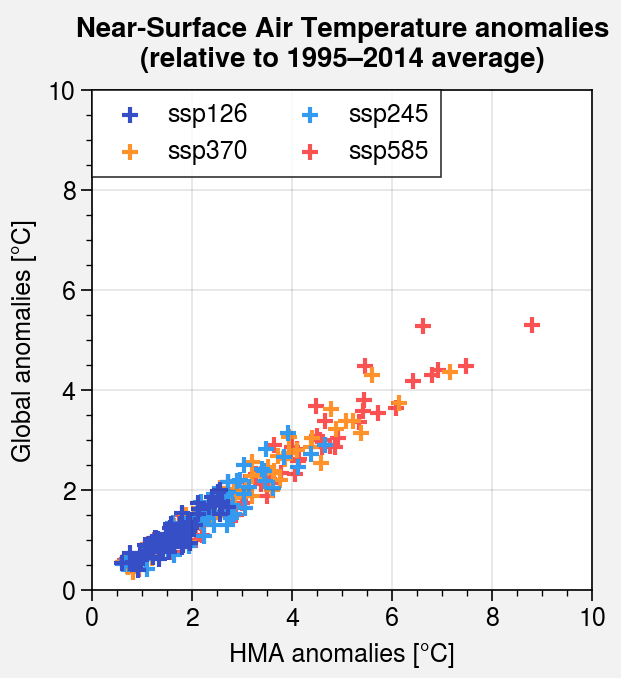

In [12]:
season='Annual'
colors = ['indigo9', 'blue5', 'orange5', 'red6']
clim_ref = mm_past_ym_zones.sel(season=season, year=slice('1995','2014')).mean('year')

fig, axs = plot.subplots()

for i, scenario in enumerate(scenarios):
    x = []
    y = []
    
    y_start = 2015
    y_end = 0
    delta = 10
    
    while y_end < 2100-delta:
        y_end = y_start + 20 - 1
        
        for model in list_models:
            temp = (mm_future_ym_zones_scenarios.sel(season=season, year=slice(str(y_start),str(y_end)), scenario=scenario, model=model).mean('year') - clim_ref.sel(model=model)).squeeze()

            x.append(temp.sel(zone='HMA').values)
            y.append(temp.sel(zone='GLOB').values)
        
        y_start += delta
    
    # Plot
    axs[0].scatter(x, y, color=colors[i], label=scenario, zorder=-i, marker='+')

lim = (0,10)
axs.format(
    xlabel='HMA anomalies [°C]',
    ylabel='Global anomalies [°C]',
    xlim=lim, ylim=lim,
    suptitle='Near-Surface Air Temperature anomalies\n(relative to 1995–2014 average)'
)

axs.legend(loc='ul', frame=True, ncols=2)

filename = 'projections/'+var+'_HMA_global'
# fig.save('img/'+filename+'.jpg'); fig.save('img/'+filename+'.png'); fig.save('img/'+filename+'.pdf')